In [3]:
! C:\Users\devae\AppData\Local\Programs\Python\Python312\python.exe -m pip install -r C:\Users\devae\Downloads\requirements.txt

  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)

The conflict is caused by:
    The user requested ipython==8.12.3
    The user requested ipython==8.27.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict



ERROR: Cannot install ipython==8.12.3 and ipython==8.27.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [3]:
import pandas as pd

splits = {'train': 'data/train.json', 'validation': 'data/val.json', 'test': 'data/test.json'}
df = pd.read_json("hf://datasets/hbfreed/Picklebot-2M/" + splits["train"])

c:\Users\devae\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df.head()

,date,pitch,mph,spin_rate,pitcher,batter,zone,count,inning,pitch_result,video_link
0,2021-05-01,FF,96.6,2478,"Scott, Tanner(L)","Piscotty, Stephen(R)",12,1-2,Bot 8,Ball,https://baseballsavant.mlb.com/sporty-videos?p...
1,2021-06-03,KC,80.7,2663,"Workman, Brandon(R)","Alvarez, Yordan(L)",13,0-2,Bot 9,Ball,https://baseballsavant.mlb.com/sporty-videos?p...
2,2023-04-25,SI,91.0,2055,"Pérez, Martín(L)","Maile, Luke(R)",14,0-0,Bot 3,Ball,https://baseballsavant.mlb.com/sporty-videos?p...
3,2020-09-27,FF,93.5,1715,"Rodriguez, Nivaldo(R)","Odor, Rougned(L)",11,0-2,Bot 5,Ball,https://baseballsavant.mlb.com/sporty-videos?p...
4,2017-09-23,FF,99.2,2554,"Ellington, Brian(R)","Lamb, Jake(L)",11,2-0,Bot 6,Ball,https://baseballsavant.mlb.com/sporty-videos?p...


In [5]:
#get all unique pitch types
pitch_types = df['pitch'].unique()
print("Unique pitch types:", pitch_types)
#filter for only SL
df = df[df['pitch'] == 'CU']

Unique pitch types: ['FF' 'KC' 'SI' 'SL' 'CU' 'CH' 'FC' 'FA' 'ST' 'FS' '' 'SV' 'KN' 'EP' 'SC'
 'FO' 'CS']


In [6]:
#get size
print(df.shape)
#get the data type of mph
print(df['mph'].dtype)
#convert mph to a float from a string
df['mph'] = pd.to_numeric(df['mph'], errors='coerce')
df = df.dropna(subset=['mph'])
print(df.shape)
print(df['mph'].mean())

(176664, 11)
object
(176654, 11)
78.2234831931346


In [7]:
#get counts of pitch_result
df['pitch_result'].value_counts()

pitch_result
Ball             113806
Called Strike     62848
Name: count, dtype: int64

In [8]:
#print the min, 25th, 50th, 75th and max percentiles of mph
print(df['mph'].describe())

count    176654.000000
mean         78.223483
std           3.776669
min          43.100000
25%          75.800000
50%          78.400000
75%          80.800000
max          94.600000
Name: mph, dtype: float64


In [9]:
import cv2
import numpy as np
import requests
from bs4 import BeautifulSoup

def get_video_url(play_id):
    url = f"https://baseballsavant.mlb.com/sporty-videos?playId={play_id}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    video_tag = soup.find("video")
    if video_tag:
        source_tag = video_tag.find("source")
        if source_tag and source_tag.get("src"):
            return source_tag["src"]
    return None

def get_video(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    video_tag = soup.find("video")
    if video_tag:
        source_tag = video_tag.find("source")
        if source_tag and source_tag.get("src"):
            return source_tag["src"]
    return None

def download_video(video_url, output_file="temp.mp4"):
    r = requests.get(video_url, stream=True)
    with open(output_file, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)

def video_to_numpy(video_path, resize=None, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if resize:
            frame = cv2.resize(frame, resize)
        frames.append(frame)
        count += 1
        if max_frames and count >= max_frames:
            break

    cap.release()
    return np.array(frames)

def save_numpy_array(array, filename="video_frames.npy"):
    np.save(filename, array)


Prompt:
The seconds when the pitcher is possibly in the middle, and the location of the pitchers change depending on the video. We may have to use ML for this.



ChatGPT said:
You're absolutely right — since the pitcher’s timing and location vary from video to video, a fixed crop won't work well. This is a classic use case for computer vision with machine learning. Here’s a structured way to approach it:

✅ Goal:
Automatically detect and crop the pitcher across different videos with varying camera angles and timings.

🧠 Solution Options:
Option 1: Pose Estimation (Recommended)
Use a pre-trained pose estimation model like:

OpenPose

MediaPipe Pose (Google)

YOLO + Keypoint detection

✅ Pros:

Accurate for identifying human bodies.

Can isolate the pitcher based on pose and movement patterns.

Option 2: Object Detection
Train or use a model (like YOLOv5, YOLOv8, or Detectron2) to detect “pitcher” as a custom class.

✅ Pros:

Works on frame-by-frame basis.

More precise than pose estimation in cluttered scenes.

❌ Cons:

Requires labeled data (you may need to annotate a small dataset of frames showing pitchers).

🔧 Workflow Example (with MediaPipe Pose in Colab):
python
Copy
Edit
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def detect_pitcher_bbox(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    bboxes = []

    for i in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        h, w, _ = frame.shape

        # Run pose estimation
        results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks:
            # Get min/max of landmark coordinates for bounding box
            x_coords = [lmk.x for lmk in results.pose_landmarks.landmark]
            y_coords = [lmk.y for lmk in results.pose_landmarks.landmark]
            xmin, xmax = min(x_coords), max(x_coords)
            ymin, ymax = min(y_coords), max(y_coords)

            # Convert to pixel coordinates
            x, y = int(xmin * w), int(ymin * h)
            width, height = int((xmax - xmin) * w), int((ymax - ymin) * h)
            bboxes.append((x, y, width, height))

    cap.release()
    return bboxes
This gives you approximate bounding boxes of the pitcher from the first max_frames frames.

🧪 Next Steps:
You can either:

Crop each frame using the detected bounding box.

Track the pitcher across frames.

Save the cropped regions into a new video or a NumPy array.

Let me know if you want help setting up pose-based cropping, YOLO training with pitcher labels, or a pipeline to auto-crop and save video segments.

In [19]:
from ultralytics import YOLO
import cv2

# Load YOLOv8 model once globally, force to use GPU if available
model = YOLO('yolov8s.pt')
if hasattr(model, 'to'):
    model.to('cuda')

def detect_and_draw_lowest_human(frame):
    """
    Detects the lowest human in the frame using YOLOv8, running on GPU if available.
    Returns the original frame and the bounding box (x1, y1, x2, y2) of the lowest person.
    Does NOT draw the bounding box.
    """
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.predict(rgb_frame, device=0, verbose=False)[0]

    lowest_y2 = -1
    lowest_box = None

    for box in results.boxes:
        cls = int(box.cls[0])
        if model.names[cls] == 'person':
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if y2 > lowest_y2:
                lowest_y2 = y2
                lowest_box = (x1, y1, x2, y2)

    return frame, lowest_box



In [11]:
# prompt: pull each video from the video output folder, and go through each one in a while loop, converting it to a numpy array

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim

def ssim_diff(frame1, frame2):
    grayA = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

#create a function to go through the video numpy array frame by frame and identify the gradient between each frame by a percentage
def gradient_analysis(frames_array):
    grad_arr = []
    for i in range(1, len(frames_array)):
        #calculate the gradient between the current frame and the previous frame
        grad = ssim_diff(cv2.resize(frames_array[i], (100,100)), cv2.resize(frames_array[i-1], (100,100)))
        grad_arr.append(grad)
        #plot the grad_arr
    plt.plot(grad_arr)
    plt.show()
    return grad_arr
#given the grad_arr, we want to crop out the parts in frames array before or after the value in grad_arr goes below 0.4, keep the middle of the video
def crop_video(frames_array, grad_arr):
    for i in range(int(len(grad_arr))):
        if grad_arr[i] < 0.4:
            return [frames_array[:i], frames_array[i+3:]]
    return [frames_array]
#after we crop, convert video to mp4 and save
def convert_video(frames_array, output_path):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (frames_array.shape[2], frames_array.shape[1]))
    for frame in frames_array:
        out.write(frame)
    out.release()
    return output_path

#create a function to use MediaPipe Pose from google to identify the bounding box of all the players
def detect_pitcher_bbox(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    bboxes = []
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    for i in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        h, w, _ = frame.shape



import os
import numpy as np
import cv2

def process_videos_in_folder(input_folder, output_folder):
    """
    Iterates through each MP4 video in the input folder, processes it to find the lowest human,
    crops the video around that human, and saves the result in the output folder.

    Args:
        input_folder (str): The path to the folder containing input videos.
        output_folder (str): The path to the folder where processed videos will be saved.
    """
    if not os.path.isdir(input_folder):
        print(f"Error: Input folder not found at {input_folder}")
        return

    os.makedirs(output_folder, exist_ok=True)

    video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]

    if not video_files:
        print(f"No MP4 videos found in {input_folder}")
        return

    for video_file in video_files:
        video_path = os.path.join(input_folder, video_file)
        print(f"Processing video: {video_path}")

        frames_array = video_to_numpy(video_path)

        gradient_array = gradient_analysis(frames_array)
        print(f"Gradient array shape: {np.array(gradient_array).shape}")
        print(f"Gradient array: {gradient_array}")

        cropped_frames = crop_video(frames_array, gradient_array)

        for i in range(len(cropped_frames)):
            print(f"Cropped frames array shape: {np.array(cropped_frames[i]).shape}")

            bounding_boxes = []
            annotated_frames = []

            for frame in cropped_frames[i]:
                annotated_frame, bbox = detect_and_draw_lowest_human(frame)
                if bbox:
                    bounding_boxes.append(bbox)
                    annotated_frames.append(annotated_frame)

            if not bounding_boxes:
                print("No humans detected in this segment. Skipping.")
                continue

            x1s, y1s, x2s, y2s = zip(*bounding_boxes)
            crop_x1, crop_y1 = max(0, min(x1s)), max(0, min(y1s))
            crop_x2, crop_y2 = min(frame.shape[1], max(x2s)), min(frame.shape[0], max(y2s))
            if crop_y2 - crop_y1 > 550:
                continue

            final_frames = [
                frame[crop_y1:crop_y2, crop_x1:crop_x2] for frame in annotated_frames
            ]

            output_filename = f"cropped_{i}_{video_file}"
            output_path = os.path.join(output_folder, output_filename)
            result_path = convert_video(np.array(final_frames), output_path)

            print(f"Cropped video saved to: {result_path}")

        # Cleanup
        try:
            del frames_array
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del gradient_array
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del cropped_frames
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del final_frames
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del annotated_frames
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del bounding_boxes
        except NameError as e:
            print(f"NameError: {e}")
        try:
            del result_path
        except NameError as e:
            print(f"NameError: {e}")

Processing row index: 11, play_id: 965fe32f-9919-4305-acc2-e8e4aed4f5f9
Frames array shape: (376, 720, 1280, 3)


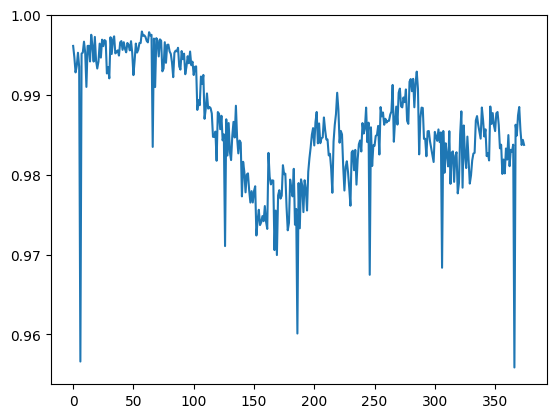

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:
import os
import re

# Update output folder path
output_folder = "Video Outputs/"


import tempfile
import os

def crop_video_size(frames_array, detect_and_draw_fn):
    """
    Processes a video in numpy array format, detects the lowest human in each frame,
    crops all frames to the bounding box covering all detected humans, and returns
    the cropped video as a numpy array.

    Args:
        frames_array (np.ndarray): Input video as a numpy array (frames, H, W, C).
        detect_and_draw_fn (function): Function to detect and return (frame, bbox) for each frame.

    Returns:
        np.ndarray: Cropped video as a numpy array.
    """
    bounding_boxes = []
    annotated_frames = []

    for frame in frames_array:
        annotated_frame, bbox = detect_and_draw_fn(frame)
        if bbox:
            bounding_boxes.append(bbox)
            annotated_frames.append(annotated_frame)

    if not bounding_boxes:
        print("No humans detected in this video. Returning original frames.")
        return frames_array

    x1s, y1s, x2s, y2s = zip(*bounding_boxes)
    crop_x1, crop_y1 = max(0, min(x1s)), max(0, min(y1s))
    crop_x2, crop_y2 = min(frames_array.shape[2], max(x2s)), min(frames_array.shape[1], max(y2s))
    if crop_y2 - crop_y1 > 550:
        print("Cropped area too large, returning original frames.")
        return frames_array

    final_frames = [
        frame[crop_y1:crop_y2, crop_x1:crop_x2] for frame in annotated_frames
    ]

    return np.array(final_frames)

def process_videos_from_df_numpy(df, n_rows, output_folder):
    """
    Processes the first n_rows of the DataFrame to download, convert to numpy, crop, and save videos.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'video_link' column.
        n_rows (int): The number of rows to process.
        output_folder (str): Where to save cropped videos or arrays.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created folder: {output_folder}")

    for index, row in df.head(n_rows).iterrows():
        video_page_url = row['video_link']

        if pd.notna(video_page_url) and video_page_url:
            match = re.search(r"playId=([a-z0-9\-]+)", video_page_url)
            if not match:
                print(f"Could not extract playId from URL: {video_page_url}")
                continue

            play_id = match.group(1)
            print(f"Processing row index: {index}, play_id: {play_id}")
            #try:
            video_url = get_video_url(play_id)
            if not video_url:
                raise ValueError("get_video_url returned None")

            # Download to a temp file
            with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as tmp:
                download_video(video_url, tmp.name)
                temp_video_path = tmp.name

            # Convert to numpy array
            frames_array = video_to_numpy(temp_video_path)

            # Crop/process frames_array as needed
            # Example: gradient analysis and cropping
            print(f"Frames array shape: {np.array(frames_array).shape}")
            gradient_array = gradient_analysis(frames_array)
            cropped_frames = crop_video(frames_array, gradient_array)

            # Save only the cropped video or numpy array
            for i, frames in enumerate(cropped_frames):
                output_filename = os.path.join(output_folder, f"cropped_{play_id}_{i}.mp4")
                output_vid = crop_video_size(np.array(frames),detect_and_draw_lowest_human)
                convert_video(output_vid, output_filename)
                print(f"Cropped video saved to: {output_filename}")

            # Remove temp file
            os.remove(temp_video_path)

            #except Exception as e:
                #print(f"Error processing video for row {index}: {e}")
        else:
            print(f"Skipping row {index} due to missing video_link.")

# Example usage: Process the first 5 rows and save to 'Video Outputs' folder
process_videos_from_df_numpy(df, 50, output_folder+"cropping_videos/")

In [16]:
import torch
import numpy as np

x = np.array([1, 2, 3])
t = torch.from_numpy(x)  # This should not raise an error


In [ ]:
!pip install mediapipe opencv-python

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose_model = mp_pose.Pose(static_image_mode=False, model_complexity=1)

def draw_pose(frame):
    results = pose_model.process(frame)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2),
            mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
        )
    return frame

def save_video(output_path, frames, fps):
    if not frames:
        print("No frames to save.")
        return

    h, w = frames[0].shape[:2]
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    for frame in frames:
        bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(bgr)

    out.release()
    print(f"✅ Saved pose-overlay video to: {output_path}")

def overlay_pose_and_save(video_path, output_path):
    video_array = video_to_numpy(video_path)
    posed_frames = []

    for frame in video_array:
        posed_frame = draw_pose(frame.copy())
        posed_frames.append(posed_frame)

    convert_video(np.array(posed_frames), output_path)
    print(f"Pose overlay video saved to: {output_path}")


In [ ]:
# prompt: create a function that lists all the mp4 videos in a given directory that start with the word cropped
import os
from IPython.display import HTML, display
from base64 import b64encode

def list_cropped_mp4_videos(directory):
  """
  Lists all MP4 video files in a given directory that start with 'cropped'.

  Args:
    directory (str): The path to the directory to search.

  Returns:
    list: A list of filenames (strings) that match the criteria.
  """
  cropped_videos = []
  if not os.path.isdir(directory):
    print(f"Error: Directory not found at {directory}")
    return cropped_videos

  for filename in os.listdir(directory):
    if filename.startswith('cropped') and filename.endswith('.mp4'):
      cropped_videos.append(filename)

  return cropped_videos

import cv2
from google.colab.patches import cv2_imshow
import time

def play_video_cv2(video_path, delay=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2_imshow(frame)
        time.sleep(delay / 10000.0)  # delay in seconds
    cap.release()

# Example usage:
cropped_video_files = list_cropped_mp4_videos(output_folder + "cropped_videos/")
print("Cropped MP4 videos found:")
for video_file in cropped_video_files:
  print(video_file)
  # === USAGE ===
  video_path = os.path.join(output_folder+"cropped_videos/", video_file)
  video_array = video_to_numpy(video_path)
  overlay_pose_and_save(video_path, os.path.join(output_folder+"posed_videos/", f"posed_{video_file}"))
  #display(play_video_cv2(os.path.join(output_folder+"posed_videos/", f"posed_{video_file}")))


Cropped MP4 videos found:
cropped_1_video_532ddefa-b34b-49b0-be7b-d18ea32f7e41.mp4
Pose overlay video saved to: /content/drive/My Drive/DATASCI_210/MIDS Capstone/Video Pre-processing/posed_videos/posed_cropped_1_video_532ddefa-b34b-49b0-be7b-d18ea32f7e41.mp4
cropped_0_video_3fae000e-36c1-4fd6-9669-f29f10295470.mp4
Pose overlay video saved to: /content/drive/My Drive/DATASCI_210/MIDS Capstone/Video Pre-processing/posed_videos/posed_cropped_0_video_3fae000e-36c1-4fd6-9669-f29f10295470.mp4
cropped_0_video_26cb26db-f3c9-46c3-a761-10886e5cdb7a.mp4
Pose overlay video saved to: /content/drive/My Drive/DATASCI_210/MIDS Capstone/Video Pre-processing/posed_videos/posed_cropped_0_video_26cb26db-f3c9-46c3-a761-10886e5cdb7a.mp4
cropped_0_video_7e5b7031-90bd-447c-b1e3-9ffd6e7f1b0b.mp4
Pose overlay video saved to: /content/drive/My Drive/DATASCI_210/MIDS Capstone/Video Pre-processing/posed_videos/posed_cropped_0_video_7e5b7031-90bd-447c-b1e3-9ffd6e7f1b0b.mp4
cropped_1_video_d03fb526-e813-4b74-897e-5c

In [18]:
import torch
print(torch.cuda.is_available())  # True if CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
#put a torch tensor on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Example: Create a tensor and move it to the GPU
tensor = torch.tensor([1.0, 2.0, 3.0]).to(device)
# Check if the tensor is on the GPU
print(f"Tensor is on GPU: {tensor.is_cuda}")
# Check if the tensor is on the GPU




True
0
NVIDIA GeForce RTX 5060 Ti
Using device: cuda
Tensor is on GPU: True
